In [3]:
import cv2
import mediapipe as mp
import numpy as np
import os
import time
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt


2024-10-31 16:31:05.435969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 16:31:05.694577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 16:31:05.903473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730381466.110989    2978 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730381466.160951    2978 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 16:31:06.665582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
landmark_data =np.load("landmark_data.npy")
labels = np.load("labels.npy")

In [5]:
landmark_data = landmark_data / np.max(landmark_data)

# Encode labels as integers and convert to categorical
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [270]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(landmark_data, labels_categorical, test_size=0.2, random_state=42)

In [5]:
# Build 1D CNN model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/home/diana/.pyenv/versions/3.10.6/envs/sign_language_interpreter/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-30 00:11:14.241416: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience = 5, restore_best_weights=True)

# Train the model
model.fit(X_train[..., np.newaxis], y_train, epochs=40, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), callbacks=es)
#model.save("asl_sign_language_model.h5")
save_model(model, 'asl_sign_language_model_tf_2.18.keras')

Epoch 1/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4350 - loss: 1.8901 - val_accuracy: 0.9456 - val_loss: 0.2025
Epoch 2/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8631 - loss: 0.4336 - val_accuracy: 0.9695 - val_loss: 0.1150
Epoch 3/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9054 - loss: 0.3007 - val_accuracy: 0.9799 - val_loss: 0.0882
Epoch 4/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9192 - loss: 0.2589 - val_accuracy: 0.9799 - val_loss: 0.0778
Epoch 5/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9306 - loss: 0.2184 - val_accuracy: 0.9841 - val_loss: 0.0745
Epoch 6/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9380 - loss: 0.1964 - val_accuracy: 0.9855 - val_loss: 0.0633
Epoch 7/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9370 - loss: 0.2019 - val_accuracy: 0.9868 - val_loss: 0.0566
Epoch 8/40
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9479 - los

In [7]:
# Load the trained model

model = tf.keras.models.load_model("asl_sign_language_model_tf_2.18.keras")

2024-10-31 16:31:38.288891: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [31]:
def adjust_brightness_contrast(image, brightness=40, contrast=1.0):
    # Convert to float to prevent clipping
    img = image.astype(np.float32)
    # Adjust brightness and contrast
    img = img * contrast + brightness
    # Clip to keep pixel values between 0 and 255 and convert back to uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [72]:
def predict_image(directory):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1,min_detection_confidence=0.4)
    mp_drawing = mp.solutions.drawing_utils

    img = cv2.imread(directory)
    img = adjust_brightness_contrast(img, 40, 1)
    img_rbg =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rbg)

    sequence = []
    sequence_length = 1

    if result.multi_hand_landmarks:
        landmarks = []
        for lm in result.multi_hand_landmarks[0].landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

        # Draw hand landmarks on the frame
        mp_drawing.draw_landmarks(
            img,
            result.multi_hand_landmarks[0],
            mp_hands.HAND_CONNECTIONS
        )

        # Append new frame landmarks to sequence

        sequence.append(landmarks)
        if len(sequence) > sequence_length:
            sequence.pop(0)

        if len(sequence) == sequence_length:
            sequence_input = np.array(sequence)
            sequence_input = sequence_input/ np.max(landmark_data)
            sequence_input = sequence_input.flatten()[np.newaxis, ..., np.newaxis]
            prediction = model.predict(sequence_input)
            predicted_label_index = np.argmax(prediction)
            predicted_label = label_encoder.inverse_transform([predicted_label_index])
            confidence = prediction[0][predicted_label_index]

    plt.axis('off')
    plt.imshow(img)
    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


W0000 00:00:1730385231.127313   28188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730385231.242544   28188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/diana/.pyenv/versions/3.10.6/envs/sign_language_interpreter/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


array(['del'], dtype='<U5')

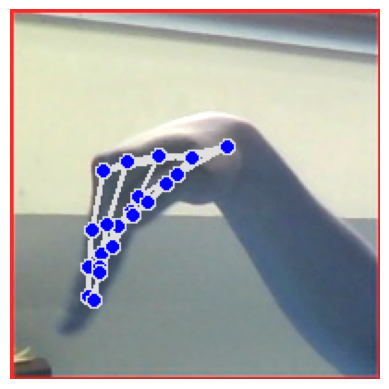

In [63]:
predict_image("/home/diana/code/Koriza274/sign_language_interpreter/raw_data/Test/del/del1.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


W0000 00:00:1730385597.044332   30982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730385597.094180   30983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/diana/.pyenv/versions/3.10.6/envs/sign_language_interpreter/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


array(['R'], dtype='<U5')

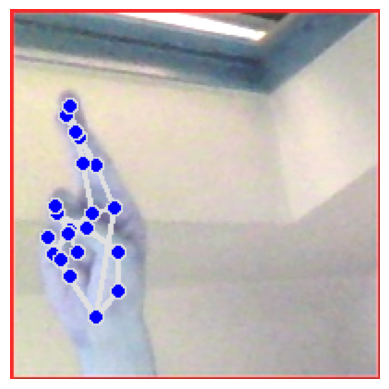

In [74]:
predict_image("/home/diana/code/Koriza274/sign_language_interpreter/basic_models/R1003.jpg")

In [67]:
def evaluate_model(test_data_dir):
        mp_hands = mp.solutions.hands
        hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.4)


        labels1 = []
        landmark_data1 = []
        img_n =0

        for letter in os.listdir(test_data_dir):

            letter_dir = os.path.join(test_data_dir, letter)
            for i, img_path in enumerate(os.listdir(letter_dir)):

                img = cv2.imread(os.path.join(letter_dir, img_path))
                img = adjust_brightness_contrast(img, 40, 1)
                img_n+=1

                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)


                if results.multi_hand_landmarks:
                    landmarks = []
                    for lm in results.multi_hand_landmarks[0].landmark:
                        landmarks.extend([lm.x, lm.y, lm.z])
                    landmark_data1.append(landmarks)
                    labels1.append(letter)
        landmark_data1 = np.array(landmark_data1)
        print(img_n)
        print(landmark_data1.shape)
        labels1 = np.array(labels1)


        # Normalize landmarks between 0 and 1
        landmark_data1 = landmark_data1 / np.max(landmark_data)

        # Encode labels as integers and convert to categorical

        labels_encoded1 = label_encoder.transform(labels1)
        labels_categorical1 = to_categorical(labels_encoded1)
        landmark_data1 = np.reshape(landmark_data1,(-1,63,1))

        return model.evaluate(landmark_data1,labels_categorical1)


In [65]:
evaluate_model("/home/diana/code/Koriza274/sign_language_interpreter/raw_data/Test")

W0000 00:00:1730385257.845652   28391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730385257.966453   28396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/diana/.pyenv/versions/3.10.6/envs/sign_language_interpreter/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


109
(109, 63)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2628 - loss: 16.0553


[17.127534866333008, 0.302752286195755]

In [68]:
model.evaluate(X_test,y_test)

NameError: name 'X_test' is not defined